In [ ]:
try:
    %tensorflow_version 2.x
except:
    pass


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Import library

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os

from tensorflow import keras
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imshow

print("\u2023 Using TensorFlow Version:", tf.__version__)
print(
    "\u2023 GPU Device Found."
    if tf.test.is_gpu_available()
    else "\u2023 GPU Device Not Found. Running on CPU"
)

‣ Using TensorFlow Version: 2.13.0
‣ GPU Device Found.


# Data Processing

In [ ]:
import zipfile

zip_path = '/content/data.zip'
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
dataset_dir=r'/content/data'


filepaths=[]
labels=[]
classlist=os.listdir(dataset_dir)

for classs in classlist:
    classpath=os.path.join(dataset_dir,classs)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(classs)

file_series= pd.Series(filepaths, name='filepaths')
label_series=pd.Series(labels, name='labels')
df=pd.concat([file_series, label_series], axis=1)

print (df['labels'].value_counts())

paper        594
glass        501
organic      500
plastic      482
metal        410
cardboard    403
Name: labels, dtype: int64


In [ ]:
train_split=.8
test_split=.1

dummy_split=test_split/(1-train_split)
train_dataframe, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_dataframe, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train data frame len: ', len(train_dataframe), '  test data frame len: ', len(test_dataframe), '  valid data frame len: ', len(valid_df))

train data frame len:  2312   test data frame len:  289   valid data frame len:  289


In [ ]:
# Set image dimensions and batch size
height = 224
width = 224
channels = 3
batch_size = 64

img_shape = (height, width, channels)
img_size = (height, width)

# Calculate test batch size and steps
length = len(test_dataframe)
test_batch_size = sorted([int(length / n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80], reverse=True)[0]
test_steps = int(length / test_batch_size)
print('test batch size:', test_batch_size, '  test steps:', test_steps)


test batch size: 17   test steps: 17


In [ ]:
# Create ImageDataGenerators
gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_gen = gen.flow_from_dataframe(
    train_dataframe,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,

)

valid_gen = gen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = gen.flow_from_dataframe(
    test_dataframe,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)

Found 2312 validated image filenames belonging to 6 classes.
Found 289 validated image filenames belonging to 6 classes.
Found 289 validated image filenames belonging to 6 classes.


In [ ]:
# Get class labels
classes = list(train_gen.class_indices.keys())
print(classes)
# print class
class_indices = train_gen.class_indices
class_count = len(classes)
print("Number of classes: ",class_indices)

['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic']
Number of classes:  {'cardboard': 0, 'glass': 1, 'metal': 2, 'organic': 3, 'paper': 4, 'plastic': 5}


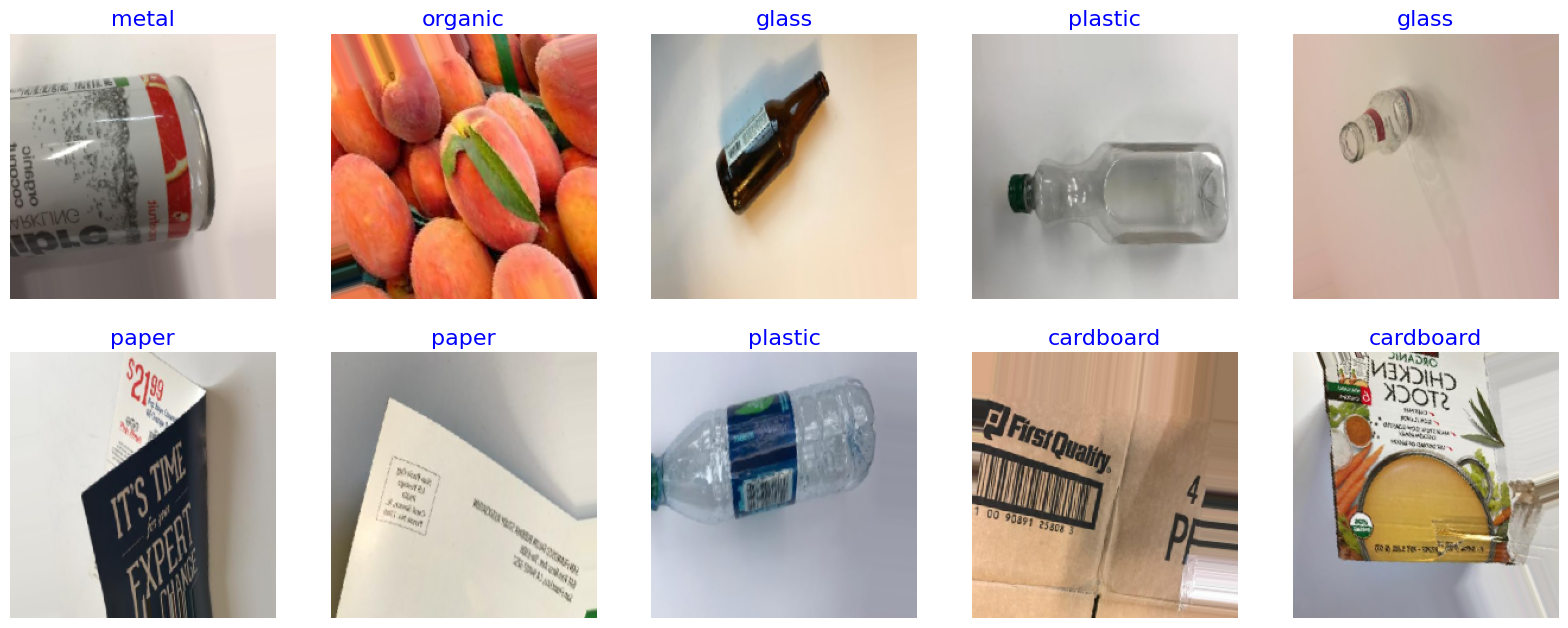

In [ ]:
def show_image_samples(gen):
    test_dict = test_gen.class_indices
    classes = list(test_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 10:
        r = length
    else:
        r = 10
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

# Example usage
show_image_samples(test_gen)


# Configuration Transfer Learning

In [ ]:
height = 224
width = 224
channels = 3

# Transfer Learning MobileNetV2
TL_model = tf.keras.applications.MobileNetV2(
    input_shape=(height, width, channels),
    alpha=1.0,
    include_top=False,
    weights="imagenet",
    input_tensor=tf.keras.layers.Input(shape=(height, width, channels)),
    pooling=None,
)

In [ ]:
TL_model.trainable = False

In [ ]:
TL_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[



# Mymodel

## Training

In [ ]:
model_name = 'Ecodo'
print("Building model with", TL_model)
model = tf.keras.Sequential([
    TL_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Building model with <keras.src.engine.functional.Functional object at 0x7beeebd77e20>


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 2422726 (9.24 MB)
Trainable params: 1647

In [ ]:
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit model with EarlyStopping callback
history = model.fit(x=train_gen, epochs=20, validation_data=valid_gen)#, callbacks=[early_stopping]

Epoch 1/20
37/37 [==============================] - 33s 888ms/step - loss: 0.2772 - accuracy: 0.8953 - val_loss: 0.3738 - val_accuracy: 0.8547
Epoch 2/20
37/37 [==============================] - 32s 862ms/step - loss: 0.2887 - accuracy: 0.8875 - val_loss: 0.4527 - val_accuracy: 0.8443
Epoch 3/20
37/37 [==============================] - 32s 861ms/step - loss: 0.2711 - accuracy: 0.9022 - val_loss: 0.3882 - val_accuracy: 0.8443
Epoch 4/20
37/37 [==============================] - 32s 864ms/step - loss: 0.2472 - accuracy: 0.9131 - val_loss: 0.4475 - val_accuracy: 0.8408
Epoch 5/20
37/37 [==============================] - 32s 853ms/step - loss: 0.2571 - accuracy: 0.9066 - val_loss: 0.4510 - val_accuracy: 0.8720
Epoch 6/20
37/37 [==============================] - 32s 862ms/step - loss: 0.2426 - accuracy: 0.9170 - val_loss: 0.4907 - val_accuracy: 0.8547
Epoch 7/20
37/37 [==============================] - 32s 855ms/step - loss: 0.2338 - accuracy: 0.9135 - val_loss: 0.4451 - val_accuracy: 0.8581

# Saved model

In [ ]:
ECODO_SAVED_MODEL = "ecodo_saved_model"

In [ ]:
tf.saved_model.save(model, ECODO_SAVED_MODEL)

In [ ]:
%%bash -s $ECODO_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['mobilenetv2_1.00_224_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_mobilenetv2_1.00_224_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_3'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 6)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


2023-12-13 12:56:34.084369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
loaded = tf.saved_model.load(ECODO_SAVED_MODEL)

In [ ]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'mobilenetv2_1_00_224_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='mobilenetv2_1.00_224_input')})
{'dense_3': TensorSpec(shape=(None, 6), dtype=tf.float32, name='dense_3')}


In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(ECODO_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = "converted_model.tflite"

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [ ]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

# Get input and output from tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Get output data
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[1.4849585e-02 8.0756645e-06 5.8611605e-04 3.3535457e-01 6.4686304e-01
  2.3386863e-03]]


In [ ]:
import shutil
shutil.make_archive("ecodo_saved_model", "zip", "ecodo_saved_model")

'/content/ecodo_saved_model.zip'

# Test

In [ ]:
# Simpan model sebagai file h5
model.save('model_ecodo.h5')


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
import numpy as np

# Mapping kelas
class_mapping = {'cardboard': 0, 'glass': 1, 'metal': 2, 'organic': 3, 'paper': 4, 'plastic': 5}

# Fungsi untuk memprediksi gambar
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = list(class_mapping.keys())[list(class_mapping.values()).index(predicted_class_index)]
    confidence = predictions[0][predicted_class_index]

    return predicted_class, confidence

# Load model
model = tf.keras.models.load_model('/content/model_ecodo.h5')

# Contoh pengujian dengan gambar
image_path = '/content/2222.jpg'
predicted_class, confidence = predict_image(model, image_path)

# Output hasil prediksi
print("Predicted Class:", predicted_class)
print("Confidence:", confidence)


1/1 [==============================] - 1s 1s/step
Predicted Class: glass
Confidence: 0.9996617


In [ ]:
# {'cardboard': 0, 'glass': 1, 'metal': 2, 'organic': 3, 'paper': 4, 'plastic': 5}